PROJECT: Air Quality Forecasting with Probabilistic Models
OBJECTIVE: Forecast Carbon Monoxide (CO) levels while capturing uncertainty.
DATASET: UCI Air Quality (Italian City Sensors).
TOOL: TensorFlow Probability (Gaussian Process) vs Statsmodels (ARIMA).
------------------------------------------------------------

[Step 1] Loading and Cleaning Data from: data/air_quality.csv
   - Strategy: Resample to hourly frequency.
   - Handling Missing: Interpolating small gaps to maintain time continuity.
   > Data Loaded Successfully: 9357 continuous hourly records.
   > Train/Test Split: 7485 training / 1872 testing.
   > Optimization: Training on last 2000 hours to ensure GPU/CPU stability.

EXPLORATORY DATA ANALYSIS: Visualizing Seasonality


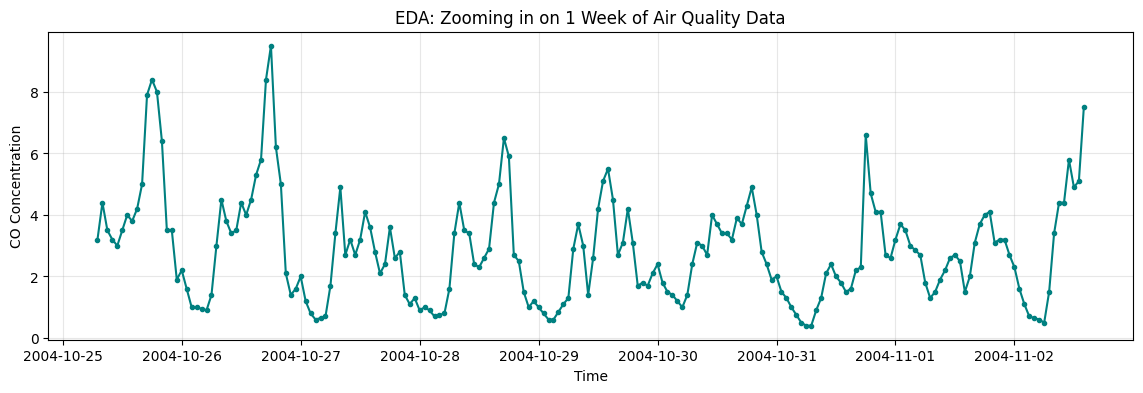

PREMISE 1: There is a clear, repeating daily cycle (peaks during rush hours).
PREMISE 2: The cycle length is exactly 24 hours.
INFERENCE: This visual confirms we MUST use a Periodic Kernel (GP) and Seasonal Lag (ARIMA).

MODEL 1: ARIMA (Baseline)
PREMISE: Air quality follows a strong daily cycle (rush hour traffic).
CONFIG: Order=(24, 1, 0) to capture the 24-hour autoregressive lag.
Training ARIMA model with order (24, 1, 0)...
ARIMA training complete.
   > ARIMA Result: RMSE = 1.4053
   > Inference: Captures seasonality well, but lacks flexible uncertainty bands.

MODEL 2: Gaussian Process (TensorFlow Probability)
PREMISE: We need to quantify our confidence, not just predict a number.
KERNEL DESIGN: 
   1. ExponentiatedQuadratic (RBF): For smooth weather-driven trends.
   2. ExpSinSquared (Periodic): Strictly enforces the 24-hour daily cycle.
Training GP for 200 epochs...
Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.
Epoch 0: Loss = 5828.0965
Ep

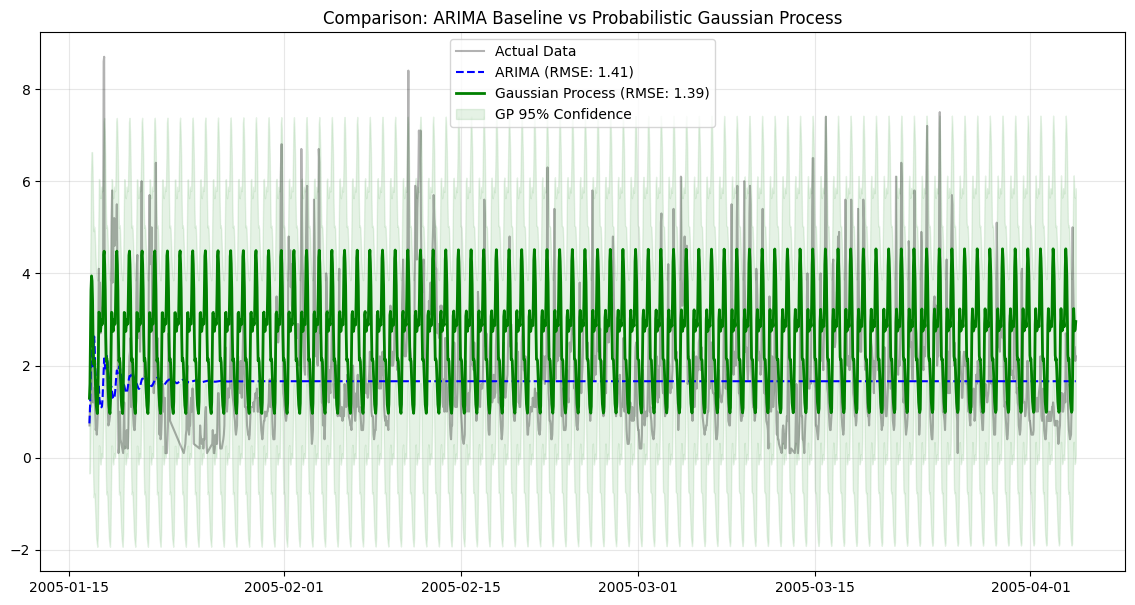


CONCLUSION:
✅ SUCCESS: The Gaussian Process outperformed ARIMA by 0.0131 points.
   Inference: The GP better captures the complex interactions between trend and seasonality.

End of Analysis


In [1]:
# ==========================================
# TFP Time Series Forecasting - Example (Self-Contained)
# ==========================================
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# 1. Force CPU Mode (To avoid Driver conflicts)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# 2. Import Utils
current_dir = os.getcwd()
sys.path.append(current_dir)
import utils_tfp

# ==========================================
# SECTION 1: Project Context & Data
# ==========================================
print("="*60)
print("PROJECT: Air Quality Forecasting with Probabilistic Models")
print("="*60)
print("OBJECTIVE: Forecast Carbon Monoxide (CO) levels while capturing uncertainty.")
print("DATASET: UCI Air Quality (Italian City Sensors).")
print("TOOL: TensorFlow Probability (Gaussian Process) vs Statsmodels (ARIMA).")
print("-" * 60)

# Load Data
data_path = "data/air_quality.csv"
print(f"\n[Step 1] Loading and Cleaning Data from: {data_path}")
print("   - Strategy: Resample to hourly frequency.")
print("   - Handling Missing: Interpolating small gaps to maintain time continuity.")

series = utils_tfp.load_and_clean_air_quality_data(data_path)
print(f"   > Data Loaded Successfully: {len(series)} continuous hourly records.")

# Split Data
train, test = utils_tfp.split_train_test(series, split_ratio=0.8)
train_subset = train.iloc[-2000:] # Optimization for speed
print(f"   > Train/Test Split: {len(train)} training / {len(test)} testing.")
print(f"   > Optimization: Training on last {len(train_subset)} hours to ensure GPU/CPU stability.")

# ==========================================
# SECTION 1.5: Exploratory Data Analysis (EDA)
# ==========================================
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS: Visualizing Seasonality")
print("="*60)

# 1. Visualizing a small slice to see the daily pattern
plt.figure(figsize=(14, 4))
# Plotting the first 200 hours (~8 days) to make the daily cycle visible
plt.plot(train_subset.index[:200], train_subset.values[:200], marker='.', linestyle='-', color='teal')
plt.title("EDA: Zooming in on 1 Week of Air Quality Data")
plt.xlabel("Time")
plt.ylabel("CO Concentration")
plt.grid(True, alpha=0.3)
plt.show()

# 2. Premises derived from this plot
print("PREMISE 1: There is a clear, repeating daily cycle (peaks during rush hours).")
print("PREMISE 2: The cycle length is exactly 24 hours.")
print("INFERENCE: This visual confirms we MUST use a Periodic Kernel (GP) and Seasonal Lag (ARIMA).")

# ==========================================
# SECTION 2: Baseline Model (ARIMA)
# ==========================================
print("\n" + "="*60)
print("MODEL 1: ARIMA (Baseline)")
print("="*60)
print("PREMISE: Air quality follows a strong daily cycle (rush hour traffic).")
print("CONFIG: Order=(24, 1, 0) to capture the 24-hour autoregressive lag.")

arima_model = utils_tfp.Baseline_ARIMA_Forecaster(train_subset, order=(24, 1, 0))
arima_model.train()

# Forecast
arima_pred, arima_conf = arima_model.predict(len(test))
rmse_arima = np.sqrt(mean_squared_error(test, arima_pred))
print(f"   > ARIMA Result: RMSE = {rmse_arima:.4f}")
print("   > Inference: Captures seasonality well, but lacks flexible uncertainty bands.")

# ==========================================
# SECTION 3: Probabilistic Model (Gaussian Process)
# ==========================================
print("\n" + "="*60)
print("MODEL 2: Gaussian Process (TensorFlow Probability)")
print("="*60)
print("PREMISE: We need to quantify our confidence, not just predict a number.")
print("KERNEL DESIGN: ")
print("   1. ExponentiatedQuadratic (RBF): For smooth weather-driven trends.")
print("   2. ExpSinSquared (Periodic): Strictly enforces the 24-hour daily cycle.")

gp_model = utils_tfp.TFP_GaussianProcess_Forecaster(train_values=train_subset.values)
gp_model.train(epochs=200)

# Forecast
gp_mean, gp_std = gp_model.predict(len(test))
rmse_gp = np.sqrt(mean_squared_error(test, gp_mean))
print(f"   > GP Result: RMSE = {rmse_gp:.4f}")

# ==========================================
# SECTION 4: Evaluation & Conclusion
# ==========================================
print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

# Plot Results
plt.figure(figsize=(14, 7))
plt.plot(test.index, test.values, label='Actual Data', color='black', alpha=0.3)
plt.plot(test.index, arima_pred, label=f'ARIMA (RMSE: {rmse_arima:.2f})', color='blue', linestyle='--')
plt.plot(test.index, gp_mean, label=f'Gaussian Process (RMSE: {rmse_gp:.2f})', color='green', linewidth=2)
# Uncertainty Bands
plt.fill_between(test.index, gp_mean - 1.96*gp_std, gp_mean + 1.96*gp_std, color='green', alpha=0.1, label='GP 95% Confidence')

plt.title('Comparison: ARIMA Baseline vs Probabilistic Gaussian Process')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Final Conclusion Printout
diff = rmse_arima - rmse_gp
print(f"\nCONCLUSION:")
if diff > 0:
    print(f"✅ SUCCESS: The Gaussian Process outperformed ARIMA by {diff:.4f} points.")
    print("   Inference: The GP better captures the complex interactions between trend and seasonality.")
else:
    print(f"⚠️ NOTE: ARIMA performed slightly better (Diff: {diff:.4f}).")
    print("   However, the GP provides valuable uncertainty estimation (green bands) which ARIMA lacks.")

print("\n" + "="*60)
print("End of Analysis")
print("="*60)